# Florence-2

In [1]:
import os
os.chdir("../")

In [2]:
import json
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv
from sklearn import metrics
plt.rc('font', family="Arial")

import matplotlib.patches as patches
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

from interpretation.submodular_detection import DetectionSubModularExplanation

In [3]:
model_id = 'microsoft/Florence-2-large-ft'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

device = "cuda"
model.to(device)
print("ok")

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


ok


In [4]:
def SubRegionDivision(image, mode="slico", region_size=30):
    element_sets_V = []
    if mode == "slico":
        slic = cv2.ximgproc.createSuperpixelSLIC(image, region_size=region_size, ruler = 20.0) 
        slic.iterate(20)     # The number of iterations, the larger the better the effect
        label_slic = slic.getLabels()        # Get superpixel label
        number_slic = slic.getNumberOfSuperpixels()  # Get the number of superpixels

        for i in range(number_slic):
            img_copp = (label_slic == i)[:,:, np.newaxis].astype(int)
            element_sets_V.append(img_copp)
    elif mode == "seeds":
        seeds = cv2.ximgproc.createSuperpixelSEEDS(image.shape[1], image.shape[0], image.shape[2], num_superpixels=50, num_levels=3)
        seeds.iterate(image,10)  # The input image size must be the same as the initialization shape and the number of iterations is 10
        label_seeds = seeds.getLabels()
        number_seeds = seeds.getNumberOfSuperpixels()

        for i in range(number_seeds):
            img_copp = (label_slic == i)[:,:, np.newaxis].astype(int)
            element_sets_V.append(img_copp)
    return element_sets_V

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image).convert('RGB')
    image_transformed = processor(images=image, return_tensors="pt")
    return image_transformed['pixel_values'][0]

In [5]:
class Florence_2_Adaptation(torch.nn.Module):
    def __init__(self, 
                 foundation_model,
                 task_prompt=None,
                 text_input=None,
                 device = "cuda"):
        super().__init__()
        self.foundation_model = foundation_model
        self.device = device
        
        self.task_prompt = task_prompt
        self.text_input = text_input
        
        self.input_ids = None
        
        self.padding_size = 40
    
    def forward(self, images, h, w):
        """_summary_

        Args:
            images (tensor): torch.Size([batch, 3, 768, 768])
        """
        batch = images.shape[0]
        input_ids = torch.stack([self.input_ids for i in range(batch)])
        
        with torch.no_grad():
            generated_ids = self.foundation_model.generate(
                input_ids=input_ids.to(device),
                pixel_values=images,
                max_new_tokens=1024,
                early_stopping=True,
                do_sample=False,
                num_beams=3,
            )
        
        generated_texts = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)
        
        prediction_logits = []
        prediction_boxes = []
        for generated_text in generated_texts:
            parsed_answer = processor.post_process_generation(
                generated_text,
                task=self.task_prompt,
                image_size=(w, h))
        
            logits = torch.from_numpy(np.array(parsed_answer['<CAPTION_TO_PHRASE_GROUNDING>']['labels'])==self.text_input).float().to(device)
            logits_padding = torch.zeros(self.padding_size-logits.shape[0]).float().to(device)
            logits_padding = torch.cat((logits, logits_padding),dim=0)
            prediction_logits.append(logits_padding.unsqueeze(1))   # add (self.padding_size, 1)
            
            boxes = torch.tensor(parsed_answer['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']).to(device)  # [np, 4]
            boxes_padding = torch.zeros((self.padding_size-logits.shape[0], 4)).to(device)
            boxes_padding = torch.cat((boxes, boxes_padding),dim=0) # (self.padding_size, 4)
            prediction_boxes.append(boxes_padding)
        
        prediction_logits = torch.stack(prediction_logits) # prediction_logits.shape = (batch, nq, 256)
        prediction_boxes = torch.stack(prediction_boxes) # prediction_boxes.shape = (batch, nq, 4)
        
        return prediction_boxes, prediction_logits 

Preparation

In [6]:
image_path = "example/tank.png"
image = cv2.imread(image_path)
target_box = [42, 115, 503, 251]
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
target_phrase = "tank"
divison_number = 50

In [7]:
grounding_model = Florence_2_Adaptation(model, 
                                        task_prompt=task_prompt, 
                                        text_input=target_phrase)
prompt = task_prompt + target_phrase
input_ids = processor(text=prompt, images=image, return_tensors="pt")['input_ids'][0].to(device)
grounding_model.input_ids = input_ids

In [8]:
# Submodular
smdl = DetectionSubModularExplanation(
    grounding_model,
    transform_vision_data,
    device="cuda",
    batch_size=20   # for 3090
)

In [9]:
# Sub-region division
image_proccess = transform_vision_data(image)
image_seg = cv2.resize(image, image_proccess.shape[1:][::-1])

region_size = int((image_seg.shape[0] * image_seg.shape[1] / divison_number) ** 0.5)

V_set = SubRegionDivision(image_seg, region_size = region_size+2)

You are using Florence-2 without a text prompt.


In [10]:
target_class = 0
S_set, saved_json_file = smdl(image, image_proccess, V_set, target_class, target_box)

100%|██████████| 46/46 [06:18<00:00,  8.22s/it]


In [11]:
with open("florence.json", "w") as f:
    f.write(json.dumps(saved_json_file, ensure_ascii=False, indent=4, separators=(',', ':')))

## Value Estimation

In [12]:
def add_value(S_set, json_file):
    single_mask = np.zeros_like(S_set[0])
    single_mask = single_mask.astype(np.float16)
    
    value_list_1 = np.array(json_file["smdl_score"])
    
    value_list_2 = np.array(
        [1-json_file["org_score"]+json_file["baseline_score"]] + json_file["smdl_score"][:-1]
    )
    
    value_list = value_list_1 - value_list_2
    
    values = []
    value = 0
    i = 0
    for smdl_single_mask, smdl_value in zip(S_set, value_list):
        value = value - abs(smdl_value)
        single_mask[smdl_single_mask==1] = value
        values.append(value)
        
        i+=1
    attribution_map = single_mask - single_mask.min()
    attribution_map = attribution_map / attribution_map.max()
    
    return attribution_map, np.array(values)

def gen_cam(image_path, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    w = mask.shape[1]
    h = mask.shape[0]
    image = cv2.resize(cv2.imread(image_path), (w,h))
    # mask->heatmap
    mask = cv2.resize(mask, (int(w/20),int(h/20)))
    mask = cv2.resize(mask, (w,h))
    heatmap = cv2.applyColorMap(np.uint8(mask), cv2.COLORMAP_COOL)  # cv2.COLORMAP_COOL
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam.astype(np.uint8), (heatmap).astype(np.uint8)

def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

In [13]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [14]:
attribution_map, _ = add_value(S_set, saved_json_file)

In [15]:
vis_saliency_map, heatmap = gen_cam(image_path, norm_image(attribution_map[:,:,0]))
vis_saliency_map = cv2.resize(vis_saliency_map, (image.shape[1], image.shape[0]))

In [16]:
def annotate_with_grounding_dino(image, boxes, phrases, color=(34,139,34)):
    """
    使用 Grounding DINO 格式化可视化目标检测结果

    参数:
        image (np.ndarray): 输入图像 (BGR) 格式
        boxes (np.ndarray): 检测框坐标，格式为 xyxy，形状为 (N, 4)
        phrases (List[str]): 每个检测框对应的类别标签列表

    返回:
        np.ndarray: 可视化的图像
    """
    # 将坐标转换为 Torch 张量，并确保数据类型一致
    boxes = torch.tensor(boxes, dtype=torch.float32)
    
    class_ids = np.zeros(len(boxes), dtype=int)
    
    # 获取图像的宽和高
    h, w, _ = image.shape

    # 确保坐标与图像尺寸匹配
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(0, w)  # 限制x坐标在图像范围内
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(0, h)  # 限制y坐标在图像范围内

    # 将框转换为 cxcywh 格式，再转换回 xyxy 格式
    xyxy_boxes = boxes.numpy()
    
    # 使用 supervision 库来进行可视化
    detections = sv.Detections(xyxy=xyxy_boxes, class_id=class_ids)

    # 初始化监督库中的注释器
    bbox_annotator = sv.BoxAnnotator(color=sv.Color(r=color[0], g=color[1], b=color[2]))
    label_annotator = sv.LabelAnnotator(color=sv.Color(r=color[0], g=color[1], b=color[2]))

    # 转换图像格式为 BGR（OpenCV 格式）
    # annotated_frame = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    annotated_frame = image
    
    # 绘制边框
    annotated_frame = bbox_annotator.annotate(scene=annotated_frame, detections=detections)
    
    # 绘制标签
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=phrases)

    return annotated_frame

In [17]:
vis_saliency_map_w_box = annotate_with_grounding_dino(vis_saliency_map, np.array([target_box]), ["tank"])

In [18]:
def visualization(image, S_set, saved_json_file, vis_image, class_name="object", index=None, mode="insertion"):
    S_set_add = S_set.copy()
    S_set_add = np.array([S_set_add[0]-S_set_add[0]] + S_set_add)
    image_baseline = cv2.resize(image, (S_set[0].shape[1], S_set[0].shape[0]))
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = (S_set[0] - S_set[0]) * image_baseline
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image_baseline)
    for smdl_sub_mask in S_set:
        insertion_image = insertion_image.copy() + smdl_sub_mask * image_baseline
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image_baseline - insertion_image)

    if mode == "insertion":
        curve_score = [saved_json_file["baseline_score"]] + saved_json_file["insertion_score"]
    elif mode == "deletion":
        curve_score = [saved_json_file["org_score"]] + saved_json_file["deletion_score"]

    if index == None:
        if mode == "insertion":
            ours_best_index = np.argmax(curve_score)
        elif mode == "deletion":
            ours_best_index = np.argmin(curve_score)
    else:
        ours_best_index = index
    x = [0.0] + saved_json_file["region_area"]
    i = len(x)

    # fig, [ax1, ax2, ax3] = plt.subplots(1,3, gridspec_kw = {'width_ratios':[2, 2, 1.5]}, figsize=(30,8))
    # fig.subplots_adjust(wspace=0.4)  # 增加wspace值，增加图2和图3之间的间隔
    fig = plt.figure(figsize=(30, 8))
    
    ax1 = fig.add_axes([0.05, 0.1, 0.3, 0.8])  # 图1位置
    ax2 = fig.add_axes([0.37, 0.1, 0.3, 0.8])  # 图2位置
    ax3 = fig.add_axes([0.75, 0.1, 0.25, 0.8])
    
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Attribution Map', fontsize=54)
    ax1.set_facecolor('white')
    ax1.imshow(vis_image[...,::-1].astype(np.uint8))
    
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(True)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Searched Region', fontsize=54)
    ax2.set_facecolor('white')
    ax2.set_xlabel("IOU Score: {:.2f}".format(curve_score[ours_best_index]), fontsize=44)
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1))
    yticks = ax3.get_yticks()
    yticks = yticks[yticks != 0]
    ax3.set_yticks(yticks)
    
    ax3.set_ylabel('IOU Score', fontsize=44)
    if mode == "insertion":
        ax3.set_xlabel('Percentage of image revealed', fontsize=44)
    elif mode == "deletion":
        ax3.set_xlabel('Percentage of image removed', fontsize=44)
    ax3.tick_params(axis='both', which='major', labelsize=36)

    if mode == "insertion":
        curve_color = "#FF4500"
    elif mode == "deletion":
        curve_color = "#1E90FF"

    x_ = x[:i]
    ours_y = curve_score[:i]
    ax3.plot(x_, ours_y, color=curve_color, linewidth=3.5)  # draw curve
    ax3.set_facecolor('white')
    ax3.spines['bottom'].set_color('black')
    ax3.spines['bottom'].set_linewidth(2.0)
    ax3.spines['top'].set_color('none')
    ax3.spines['left'].set_color('black')
    ax3.spines['left'].set_linewidth(2.0)
    ax3.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax3.scatter(x_[-1], ours_y[-1], color=curve_color, s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax3.fill_between(x_, ours_y, color=curve_color, alpha=0.1)

    kernel = np.ones((10, 10), dtype=np.uint8)
    # ax3.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线
    ax3.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线

    # Ours
    if mode == "insertion":
        mask = (S_set_add.sum(0) - S_set_add[:ours_best_index+1].sum(0)).sum(-1).astype('uint8')
    elif mode == "deletion":
        mask = 1-(S_set_add.sum(0) - S_set_add[:ours_best_index+1].sum(0)).sum(-1).astype('uint8')

    if ours_best_index != 0:
        dilate = cv2.dilate(mask, kernel, 3)
        # erosion = cv2.erode(dilate, kernel, iterations=3)
        # dilate = cv2.dilate(erosion, kernel, 2)
        edge = dilate - mask
        # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image_baseline.copy()
    image_debug[mask>0] = image_debug[mask>0] * 0.3
    if ours_best_index != 0:
        image_debug[edge>0] = np.array([0,0,255])
    
    if mode == "insertion":
        if ours_best_index != 0:
            target_box = saved_json_file["insertion_box"][ours_best_index-1]
            cls_score = saved_json_file["insertion_cls"][ours_best_index-1]
        else:
            target_box = saved_json_file["deletion_box"][-1]
            cls_score = saved_json_file["deletion_cls"][-1]
        color=(255,69,0)
    elif mode == "deletion":
        if ours_best_index != 0:
            target_box = saved_json_file["deletion_box"][ours_best_index-1]
            cls_score = saved_json_file["deletion_cls"][ours_best_index-1]
        else:
            target_box = saved_json_file["insertion_box"][-1]
            cls_score = saved_json_file["insertion_cls"][-1]
        color=(30,144,255)
    image_debug = cv2.resize(image_debug, (image.shape[1],image.shape[0]))
    image_debug = annotate_with_grounding_dino(image_debug, np.array([target_box]), ["{}: {:.2f}".format(class_name, cls_score)], color)
    ax2.imshow(image_debug[...,::-1])
    print(image_debug.shape)
    
    auc = metrics.auc(x, curve_score)
    if mode == "insertion":
        ax3.set_title('Insertion {:.4f}'.format(auc), fontsize=54)
    elif mode == "deletion":
        ax3.set_title('Deletion {:.4f}'.format(auc), fontsize=54)

(297, 512, 3)


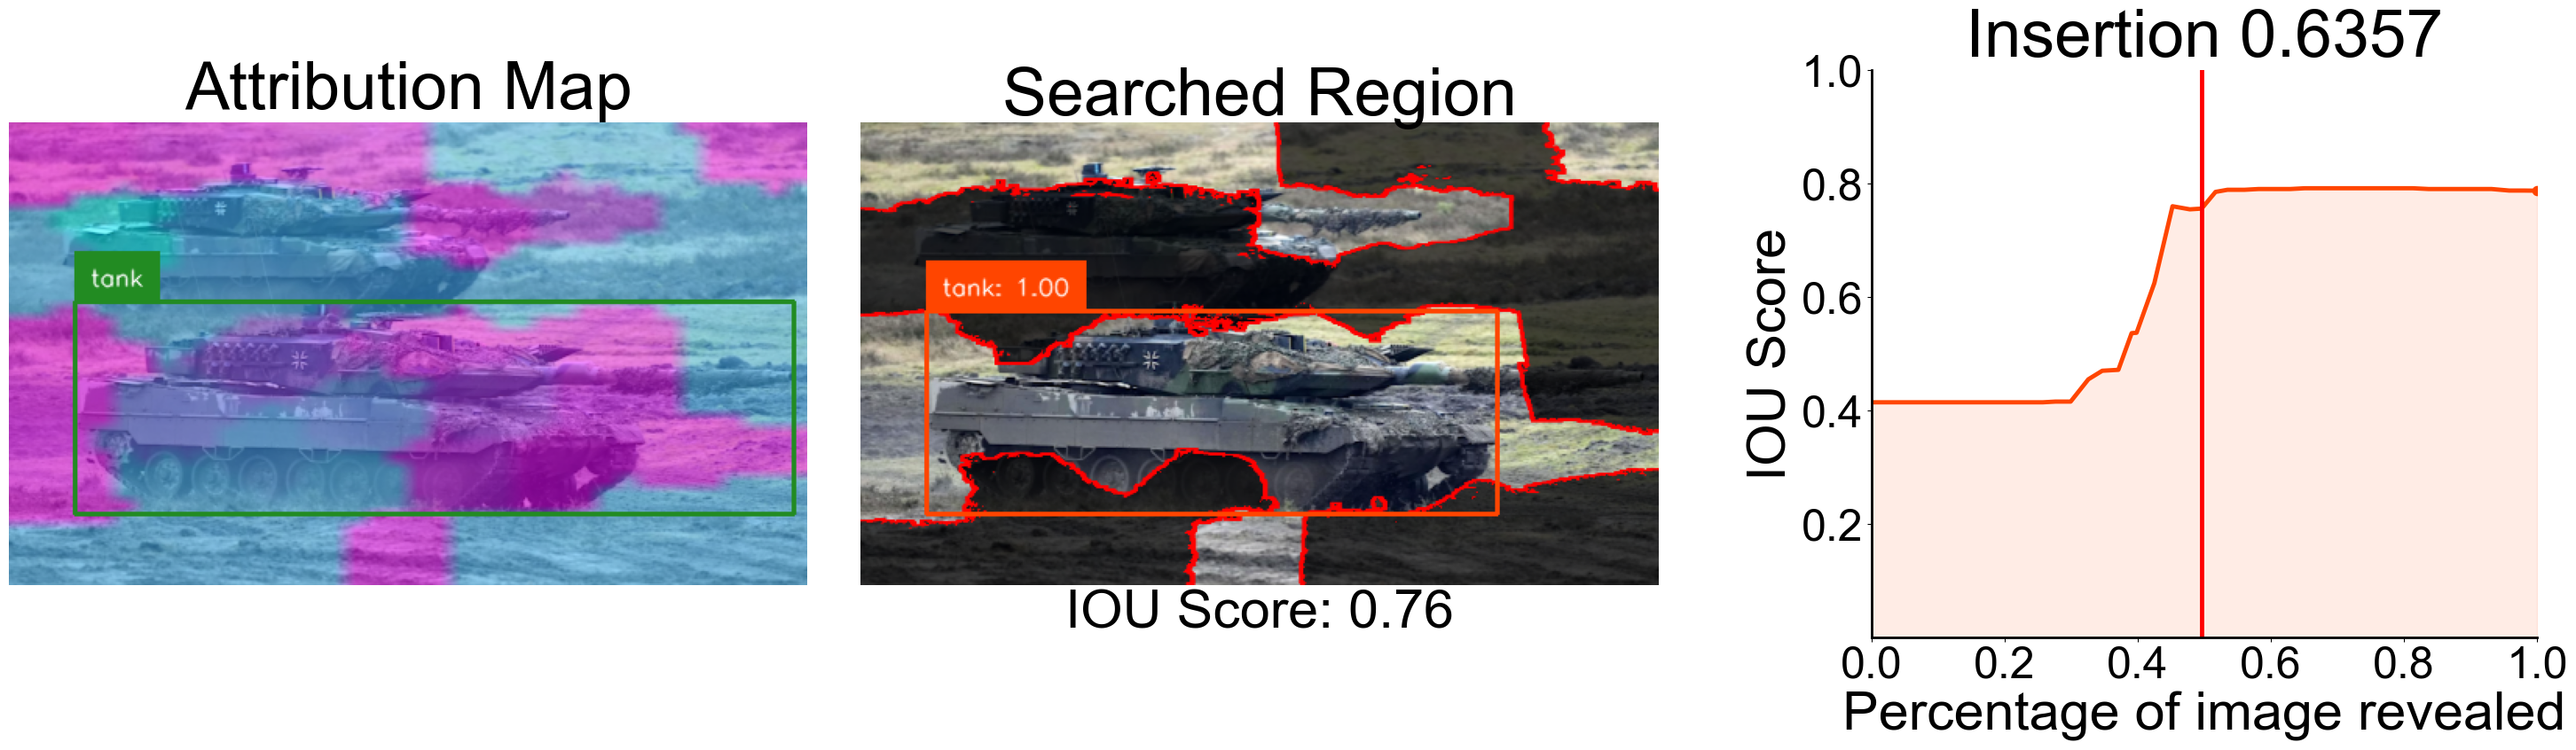

In [25]:
visualization(image, S_set, saved_json_file, vis_saliency_map_w_box, "tank",22)

(297, 512, 3)


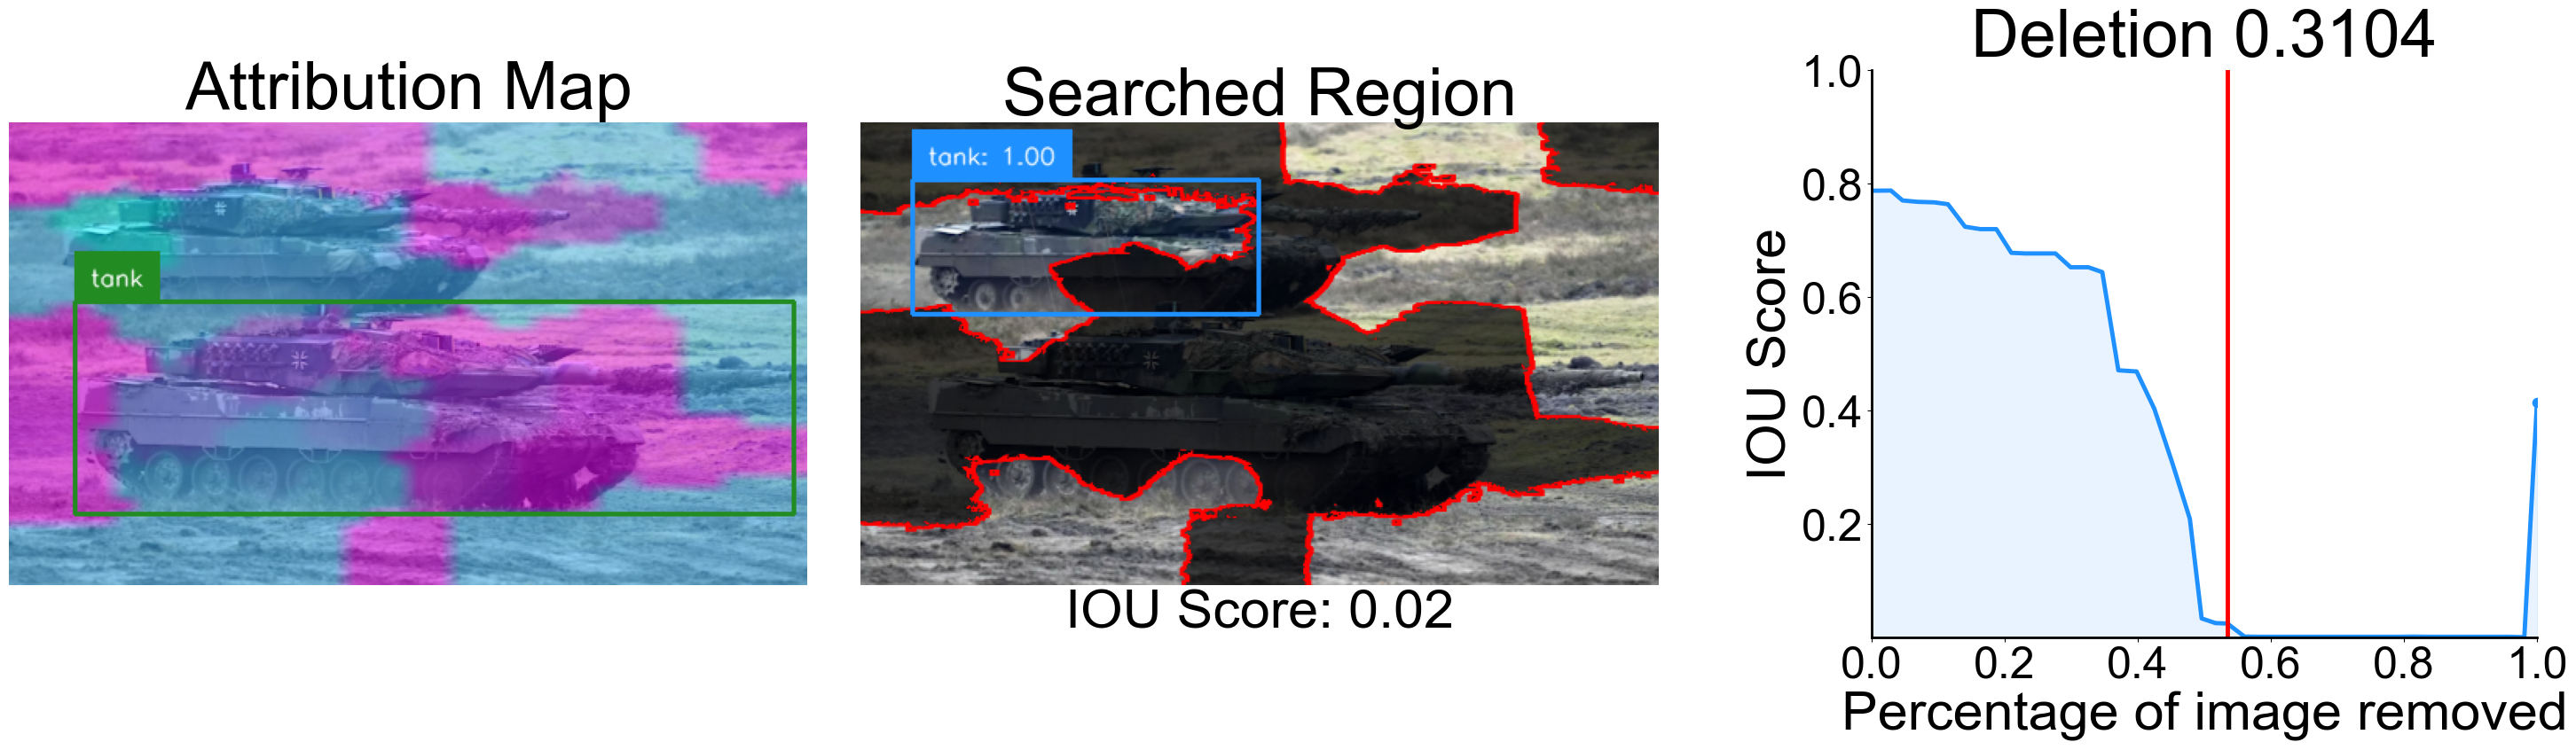

In [28]:
visualization(image, S_set, saved_json_file, vis_saliency_map_w_box, "tank", 24, mode="deletion")